### 임의의 네트워크 만들어보기

- 노드의 크기 : 나가는 연결선 수
- 링크의 너비 : 두 사용자 간의 리트윗 수

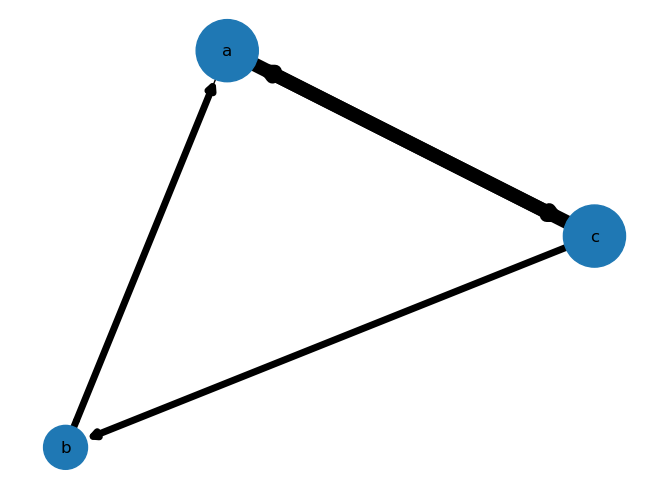

In [ ]:
import networkx as nx

s = nx.DiGraph()

s.add_weighted_edges_from([
     ('a','b',1),('a','c',10),
    ('b','a',5),
    ('c','a',10),('c','b',5)
])

node_sizes = [s.out_degree(n) * 1000 for n in s.nodes()]
edges = s.edges()
weights = [s[u][v]['weight'] for u,v in edges]

nx.draw(s, with_labels = True, node_size = node_sizes,
        width = weights)

### 트위터 api 연결

In [1]:
from twython import Twython

In [2]:
api_key = 'Z8ShlmOyVQlmhx5zg21sMWYOb'
api_secret_key = '0QVcRtmwfC1gAzwUPXeomLBF8EEAOOmuvOzP4vL9NBZ9tPYXh1'

twitter = Twython(api_key, api_secret_key)
authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=rU2ROwAAAAABh_HGAAABg8JTaZc


In [3]:
verifier = '2956655' # 위의 링크로 접속하면 확인 가능
twitter = Twython(api_key, api_secret_key,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(verifier)

In [4]:
twitter = Twython(api_key, api_secret_key,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

{'id': 1579124435046797313,
 'id_str': '1579124435046797313',
 'name': '이동현',
 'screen_name': 'networkscience_',
 'location': '',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 0,
 'friends_count': 1,
 'listed_count': 0,
 'created_at': 'Sun Oct 09 14:59:51 +0000 2022',
 'favourites_count': 0,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': False,
 'statuses_count': 0,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'F5F8FA',
 'profile_background_image_url': None,
 'profile_background_image_url_https': None,
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/1579124490713575424/ikn4v0PJ_normal.png',
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1579124490713575424/ikn4v0PJ_normal.png',
 'profile_link_color': '1DA1F2',
 'profile_sidebar_bord

### 리트윗 네트워크 제작(game)

1. 게임을 언급한 트윗 1000개 가져오기

In [5]:
import itertools

from numpy import result_type

num_tweets = 1000

cursor = twitter.cursor(twitter.search, q= '#game', count = 100, result_type = 'mixed')
search_tweets = list(itertools.islice(cursor, num_tweets))
len(search_tweets)

1000

2. 리트윗 필터링

In [6]:
retweets = []

for tweet in search_tweets:
    if 'retweeted_status' in tweet:
        retweets.append(tweet)
len(retweets)

686

3. 그래프 제작

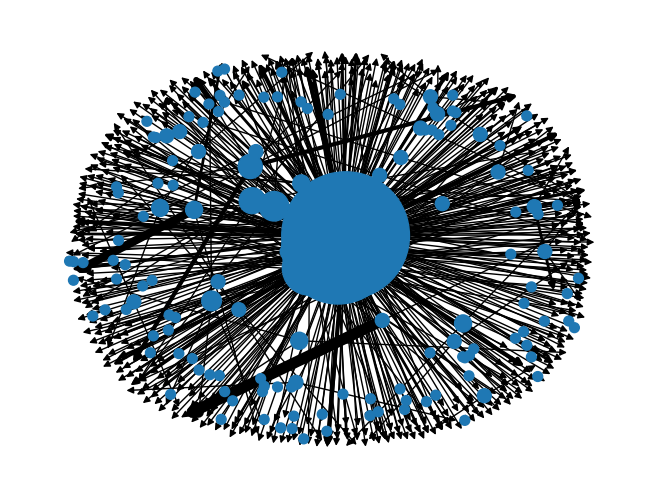

In [59]:
import networkx as nx

# 방향성 그래프 제작
g = nx.DiGraph()

# 리트윗하는 사람, 받는 사람을 가져와서 링크 생성 및 가중치 반영

for retweet in retweets :
    retweeted_status = retweet['retweeted_status']
    retweeted_sn = retweeted_status['user']['screen_name']
    retweeter_sn = retweet['user']['screen_name']

    # 링크 방향 : retweeted_sn -> retweer_sn
    if g.has_edge(retweeted_sn, retweeter_sn):
        g.edges[retweeted_sn, retweeter_sn]['weight'] += 1
    else : 
        g.add_edge(retweeted_sn, retweeter_sn, weight = 1)
        
# 나가는 연결선 수에 비례하는 노드 크기
node_sizes = [g.out_degree(n) * 50 for n in g.nodes()]

# 두 사용자 간의 리트윗 수에 따른 링크 크기
edges = g.edges()
weights = [g[u][v]['weight'] for u,v in edges]

# self-loop 제거, 싱글톤 노드는 해당 네트워크에 X

self = list(nx.selfloop_edges(g))
g.remove_edges_from(self)

nx.draw(g, node_size = node_sizes, width = weights)

In [49]:
list(nx.isolates(g)) # 싱글톤 노드 X

[]

In [60]:
list(nx.selfloop_edges(g)) # self-loop X

[]

2. 가장 많이 리트윗된 사용자

In [61]:
max(g.nodes(), key = g.out_degree())

'PG10502711'

In [62]:
from operator import itemgetter

sorted(g.out_degree(), key = itemgetter(1), reverse= True)[:5] # 리트윗을 받는 상위 5명

[('PG10502711', 169),
 ('SiamSian_No1', 132),
 ('elitegoatnation', 30),
 ('Aashraa1', 26),
 ('Matr1xOfficial', 18)]

2-1. 가장 많이 리트윗한 사용자

In [64]:
sorted(g.in_degree(weight = 'weight'), key = itemgetter(1), reverse= True)[:5]

[('RockstarGamesUp', 11),
 ('AnimatorsPal', 8),
 ('BerkleyBearNews', 8),
 ('ReGamertron', 4),
 ('thepixeldevs', 4)]

In [68]:
print(nx.is_strongly_connected(g), nx.is_weakly_connected(g))

False False


In [67]:
print(nx.number_weakly_connected_components(g),nx.number_strongly_connected_components(g))

128 735


강하게 연결된 덩어리가 많다. 즉, 게임이라는 해시태그 내부의 리트윗은 서로 연결된 집단이 다수 있음을 알 수 있다.